In [5]:
import jax
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from jax import numpy as jnp
from numpy.polynomial.hermite import hermgauss

from vibrojet.basis_utils import ContrBasis, HermiteBasis

config.update("jax_enable_x64", True)

Read KEO and PES expansion coefficients, generated in 'nh3_keo_beta.ipynb' and 'nh3_pes_beta.ipynb'

In [12]:
max_order_keo = 4
max_order_pes = 6

gmat_file = f"nh3_gmat_beta_y_coefs_{max_order_keo}.npz"
data = np.load(gmat_file)
gmat_coefs = data["coefs"]
gmat_terms = data["ind"]
keo_q0 = data["q0"]
keo_y0 = data["y0"]

pseudo_file = f"nh3_pseudo_beta_y_coefs_{max_order_keo}.npz"
data = np.load(pseudo_file)
pseudo_coefs = data["coefs"]
pseudo_terms = data["ind"]

pes_file = f"nh3_poten_beta_y_coefs_{max_order_pes}.npz"
data = np.load(pes_file)
pes_coefs = data["coefs"]
pes_terms = data["ind"]
pes_y0 = data["q0"]

# ! TODO: need to store q0 in expansion files, also a_morse
pes_q0 = np.array(
    [
        1.01159999e00,
        1.01159999e00,
        1.01159999e00,
        6.95820540e-09,
        2.12731136e-09,
        3.85722364e-01,
    ]
)
a_morse = 2.0
ncoo = len(pes_q0)

assert all(
    np.abs(pes_q0[:-1] - keo_q0[:-1]) < 1e-8
), f"Reference internal coordinates 1..5 for KEO and PES must be equal"

q0 = [q for q in pes_q0]

Transformation from expansion coordinates to internal coordinates, same expansion coordinates  were used in 'nh3_keo_beta.ipynb' and 'nh3_pes_beta.ipynb'

In [ ]:
def keo_coords(q, q0, icoo):
    if icoo in (0, 1, 2):
        return q - q0
    elif icoo in (3, 4):
        return q
    elif icoo == 5:
        rho = q + jnp.pi / 2
        return jnp.cos(rho)
    else:
        raise ValueError(f"'icoo' = {icoo} > 5")


def pes_coords(q, q0, icoo, a_morse):
    if icoo in (0, 1, 2):
        return 1.0 - jnp.exp(-a_morse * (q - q0))
    elif icoo in (3, 4):
        return q
    elif icoo == 5:
        rho = q + jnp.pi / 2
        return jnp.sin(rho)
    else:
        raise ValueError(f"'icoo' = {icoo} > 5")

In [19]:
# G-matrix at equilibrium

mask = gmat_terms != 0
ind0 = np.where(mask.sum(axis=1) == 0)[0][0]
mu = np.diag(gmat_coefs[ind0])[: len(q0)]

# first and second derivative of potential

mask = pes_terms != 0
ind1 = np.array(
    [
        np.where((mask.sum(axis=1) == 1) & (pes_terms[:, icoo] == 1))[0][0]
        for icoo in range(len(q0))
    ]
)
ind2 = np.array(
    [
        np.where((mask.sum(axis=1) == 1) & (pes_terms[:, icoo] == 2))[0][0]
        for icoo in range(len(q0))
    ]
)
dv_dy = pes_coefs[ind1]
d2v_dy2 = pes_coefs[ind2] * 2

grad = jax.grad(pes_coords)
hess = jax.grad(grad)
dy_dq = np.array([grad(pes_y0[icoo], q0[icoo], icoo, a_morse) for icoo in range(ncoo)])
d2y_dq2 = np.array(
    [hess(pes_y0[icoo], q0[icoo], icoo, a_morse) for icoo in range(ncoo)]
)

freq = d2v_dy2 * (dy_dq) ** 2 + dv_dy * d2y_dq2

# linear transformation between harmonic-oscillator coordinate (x)
# and internal coordinates (q)

lin_a = np.sqrt(np.sqrt(mu / freq))
lin_b = q0
lin_b[-1] = 0  # set center at the planar geometry

print("x->q linear mapping parameters 'a':\n", lin_a)
print("x->q linear mapping parameters 'b':\n", lin_b)

# # x->q linear mapping function
x_to_q = lambda x, icoo: lin_a[icoo] * x + lin_b[icoo]

x->q linear mapping parameters 'a':
 [0.03639106 0.03639106 0.03639106 0.27051765 0.27051765 0.07510423]
x->q linear mapping parameters 'b':
 [np.float64(1.01159999), np.float64(1.01159999), np.float64(1.01159999), np.float64(6.9582054e-09), np.float64(2.12731136e-09), 0]


Plot 1D cuts for potential

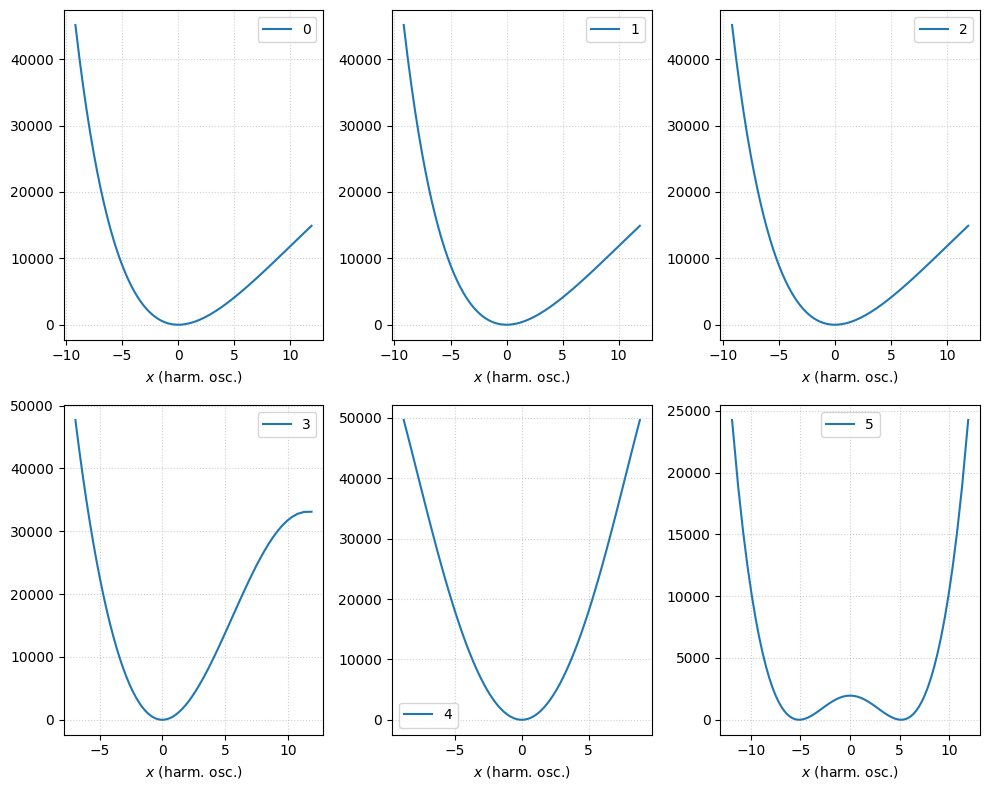

In [ ]:
# function computes potential at points
poten_taylor = jax.vmap(
    lambda y: jnp.sum(
        pes_coefs * jnp.prod((y - pes_y0)[None, :] ** pes_terms, axis=-1)
    ),
    in_axes=0,
)

fig, axes = plt.subplots(2, 3, figsize=(10, 8), dpi=100)

for icoo, ax in enumerate(axes.flat):
    x, w = hermgauss(80)
    q = x_to_q(x, icoo)
    y = pes_coords(q, q0[icoo], icoo, a_morse)

    if icoo > 2:
        q = q * 180 / np.pi

    y_6d = np.ones((len(y), 6)) * np.array(pes_y0)[None, :]
    y_6d[:, icoo] = y

    v = poten_taylor(y_6d)
    v = np.array(v)
    v[v > 50000] = None

    ax.plot(x, v, label=f"{icoo}")
    ax.set_xlabel("$x$ (harm. osc.)")

    # ax.plot(q, v, label=f"{icoo}")
    # ax.set_xlabel("$q$")

    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

plt.tight_layout()

Plot 1D cuts for different elements of $G$-matrix along the inversion coordinate $\tau$.

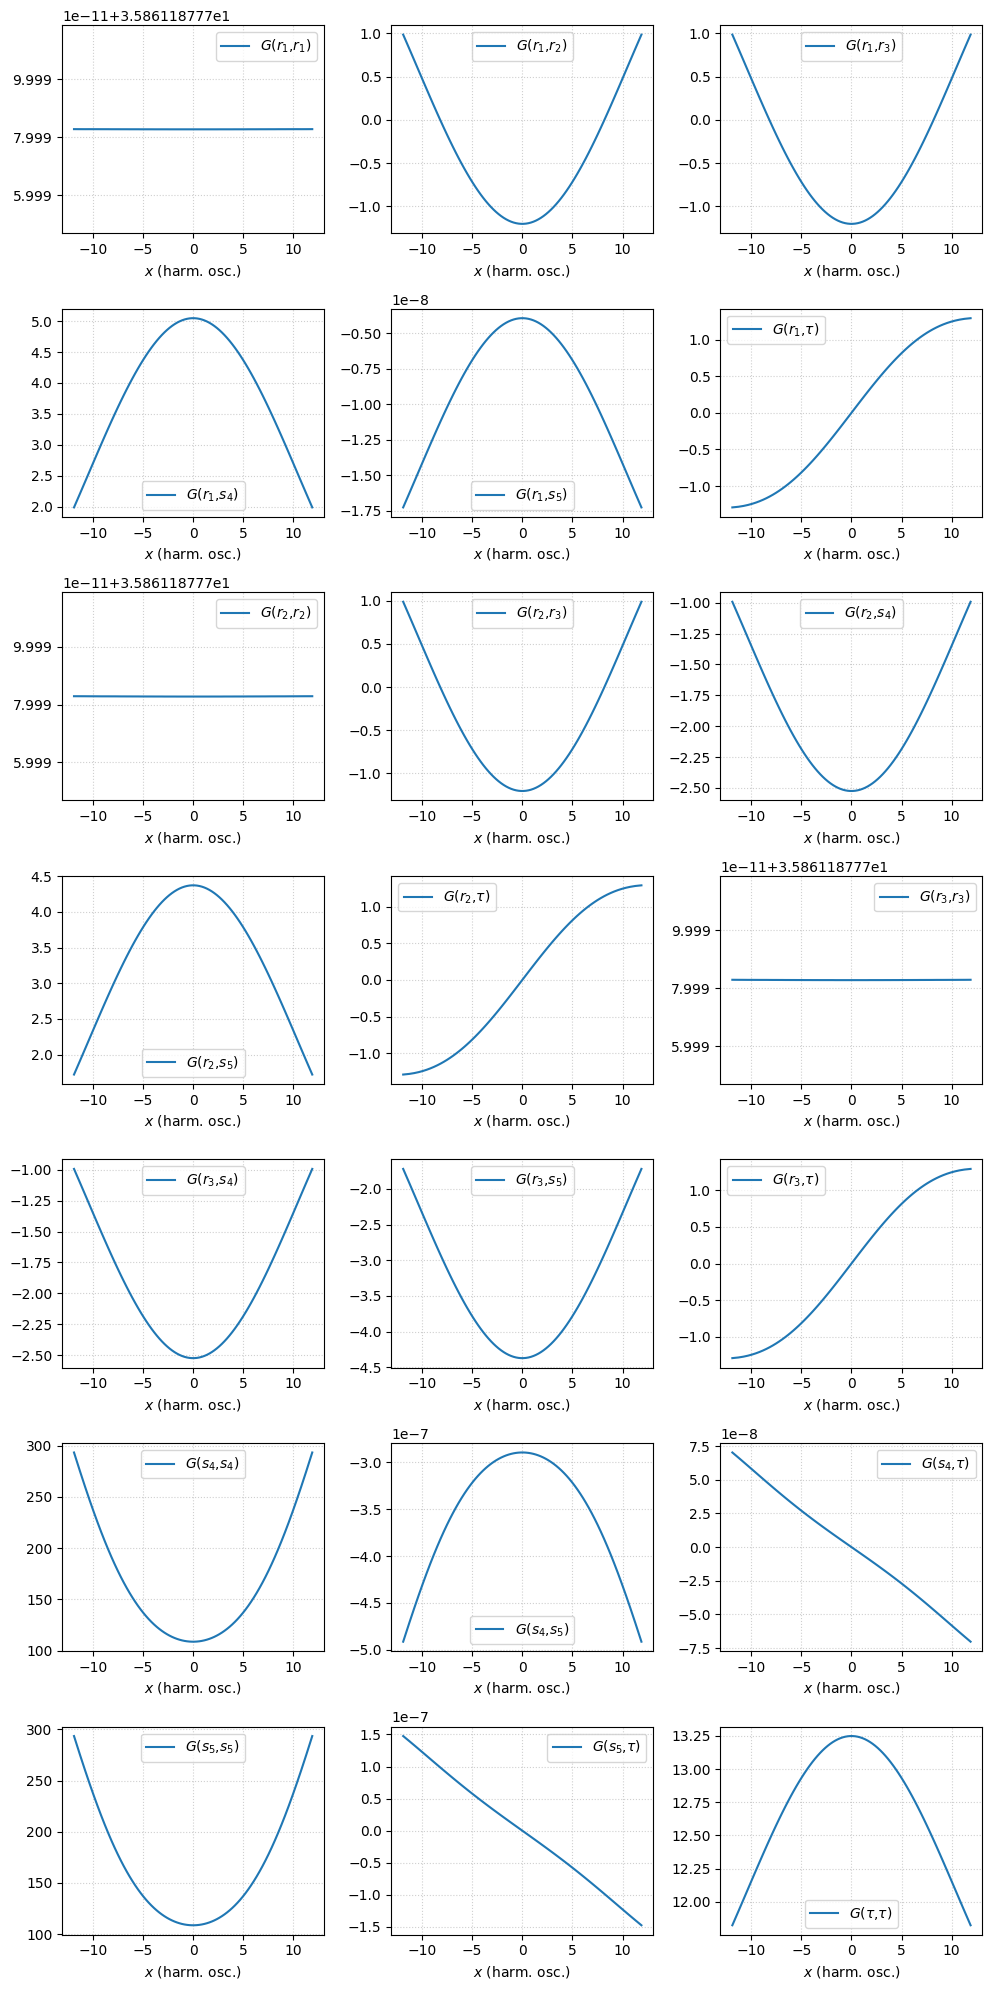

In [28]:
# function computes G-matrix at points
gmat_taylor = jax.vmap(
    lambda y: gmat_coefs.swapaxes(0, 2)
    @ jnp.prod((y - keo_y0)[None, :] ** gmat_terms, axis=-1),
    in_axes=0,
)

fig, axes = plt.subplots(7, 3, figsize=(10, 20), dpi=100)

x, w = hermgauss(80)
icoo = 5
q = x_to_q(x, icoo)
y = keo_coords(q, keo_q0[icoo], icoo)
q_deg = q * 180 / np.pi
y_6d = np.ones((len(y), 6)) * np.array(keo_y0)[None, :]
y_6d[:, icoo] = y
gmat = gmat_taylor(y_6d)

gmat = [((i, j), gmat[:, i, j]) for i in range(6) for j in range(i, 6)]
coo_label = ("$r_1$", "$r_2$", "$r_3$", "$s_4$", "$s_5$", "$\\tau$")

for ((icoo, jcoo), g), ax in zip(gmat, axes.flat):
    ax.plot(x, g, label=f"$G$({coo_label[icoo]},{coo_label[jcoo]})")
    ax.set_xlabel("$x$ (harm. osc.)")

    # ax.plot(q_deg, g, label=f"$G$({coo_label[icoo]},{coo_label[jcoo]})")
    # ax.set_xlabel("$\\tau$ (deg.)")

    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

plt.tight_layout()

Plot 1D cuts for pseudopotential

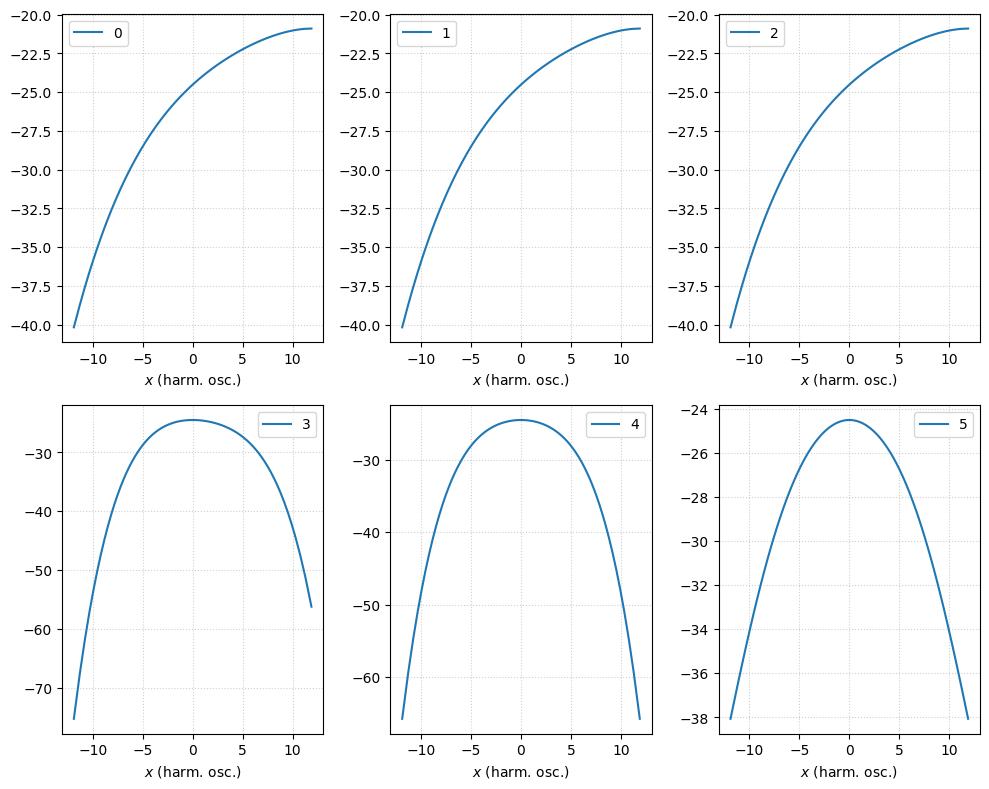

In [30]:
# function computes pseudopotential at points
pseudo_taylor = jax.vmap(
    lambda y: jnp.sum(
        pseudo_coefs * jnp.prod((y - keo_y0)[None, :] ** pseudo_terms, axis=-1)
    ),
    in_axes=0,
)

fig, axes = plt.subplots(2, 3, figsize=(10, 8), dpi=100)

for icoo, ax in enumerate(axes.flat):
    x, w = hermgauss(80)
    q = x_to_q(x, icoo)
    y = keo_coords(q, keo_q0[icoo], icoo)

    if icoo > 2:
        q = q * 180 / np.pi

    y_6d = np.ones((len(y), 6)) * np.array(keo_y0)[None, :]
    y_6d[:, icoo] = y

    v = pseudo_taylor(y_6d)

    ax.plot(x, v, label=f"{icoo}")
    ax.set_xlabel("$x$ (harm. osc.)")

    # ax.plot(q, v, label=f"{icoo}")
    # ax.set_xlabel("$q$")

    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

plt.tight_layout()

Generate primitive Hermite basis sets and matrix elements. 

In [31]:
nbas = [60] * ncoo
npoints = [80] * ncoo

p_r1, p_r2, p_r3, p_s4, p_s5, p_tau = [
    HermiteBasis(
        icoo,
        nbas[icoo],
        npoints[icoo],
        lambda x: x_to_q(x, icoo),
        lambda q: keo_coords(q, keo_q0[icoo], icoo) - keo_y0[icoo],
        lambda q: pes_coords(q, pes_q0[icoo], icoo, a_morse) - pes_y0[icoo],
        gmat_terms[:, icoo],
        pes_terms[:, icoo],
        pseudo_terms[:, icoo],
    )
    for icoo in range(ncoo)
]

Compute 1D contracted basis sets, by solving 1D reduced-mode Schrödinger equations for each coordinate.

In [36]:
c_r1, c_r2, c_r3, c_s4, c_s5, c_tau = [
    ContrBasis(
        (icoo,),
        [p_r1, p_r2, p_r3, p_s4, p_s5, p_tau],
        lambda _: True,
        gmat_terms,
        gmat_coefs,
        pes_terms,
        pes_coefs,
        pseudo_terms,
        pseudo_coefs,
        emax=40000,
    )
    for icoo in range(ncoo)
]

e = c_r1.enr
print("Solutions for r1 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r2.enr
print("\nSolutions for r2 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_r3.enr
print("\nSolutions for r3 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_s4.enr
print("\nSolutions for alpha1 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_s5.enr
print("\nSolutions for alpha2 coordinate:\n", f"zpe = {e[0]}\n", e - e[0])
e = c_tau.enr
print("\nSolutions for tau coordinate:\n", f"zpe = {e[0]}\n", e - e[0])

Solutions for r1 coordinate:
 zpe = 4729.621972771847
 [    0.          3635.3040136   7148.31238839 10627.69220082
 14310.509074   18415.63176025 23002.78587822 28027.96774212
 33493.02800066 39287.27702356]

Solutions for r2 coordinate:
 zpe = 4729.621959837439
 [    0.          3635.30401544  7148.31239019 10627.69219251
 14310.50903708 18415.63168276 23002.78575709 28027.96757608
 33493.02779005 39287.27676606]

Solutions for r3 coordinate:
 zpe = 4729.621983768766
 [    0.          3635.30401617  7148.31239473 10627.69221797
 14310.50911508 18415.63183394 23002.78598709 28027.96788739
 33493.02818251 39287.27724381]

Solutions for alpha1 coordinate:
 zpe = 3395.715321951284
 [    0.          1553.38947917  3097.78220664  4632.62639755
  6157.31358537  7671.1693142   9173.44149532 10663.28563513
 12139.74578945 13601.72954693 15047.97444862 16477.00174203
 17887.05070412 19275.98179582 20641.12696525 21979.04368155
 23285.07576812 24552.46759657 25770.18023864 26915.21326562
 27913

Compute 3D contracted basis sets for the stretching coordinates $r_1$, $r_2$, and $r_3$ by solving 3D reduced-mode Schrödinger equation, where basis functions for the bending $s_4$, $s_5$ and inversion $\tau$ coordinates are fixed to their ground (zero-order function) states.

In [37]:
c_r1_r2_r3 = ContrBasis(
    (0, 1, 2),
    [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    pes_terms,
    pes_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=30000,
)

e = c_r1_r2_r3.enr
print(len(e))
print("Solutions for r1+r2+r3 coordinates:\n", f"zpe = {e[0]}\n", e - e[0])

157
Solutions for r1+r2+r3 coordinates:
 zpe = 6287.1640302042
 [    0.          3353.56502504  3480.74089406  3481.29434975
  6657.90109033  6750.4150733   6750.94356225  6898.54902275
  6939.31469802  6939.33037083  9954.56096203 10058.5040218
 10058.98285971 10193.41037837 10193.49154084 10197.07250316
 10316.91398193 10317.89419154 10334.39698587 10392.05630101
 13248.32911978 13376.42236933 13376.81381926 13524.72561591
 13524.8760102  13580.80279904 13640.4445631  13660.45725141
 13719.42734767 13719.42948419 13771.06824973 13771.15800872
 13933.43153362 13933.62088051 13934.40648854 16543.03358867
 16695.19856958 16695.52253615 16862.55766523 16893.63868787
 16894.01716456 17009.31295735 17046.62334527 17047.50171881
 17095.66949612 17157.9856748  17158.21391173 17332.70071978
 17333.22175847 17335.6296338  17394.90878136 17394.98755116
 17404.62997685 18112.31556314 18112.35906626 18112.87520833
 19849.17928142 20059.09392913 20059.43589221 20212.88557714
 20284.56758658 20284.

Compute 2D contracted basis sets for the bending coordinates $s_4$ and $s_5$ by solving 2D reduced-mode Schrödinger equation, where basis functions for the stretching $r_1$, $r_2$, $r_3$ and inversion $\tau$ coordinates are fixed to their ground (zero-order function) states.

In [38]:
c_s4_s5 = ContrBasis(
    (3, 4),
    [c_r1, c_r2, c_r3, c_s4, c_s5, c_tau],
    lambda _: True,
    gmat_terms,
    gmat_coefs,
    pes_terms,
    pes_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=30000,
)

e = c_s4_s5.enr
print(len(e))
print("Solutions for s4+s5 coordinates:\n", f"zpe = {e[0]}\n", e - e[0])

188
Solutions for s4+s5 coordinates:
 zpe = 4611.924961143816
 [    0.          1680.71031725  1680.71032065  3342.92154809
  3365.10980404  3365.10980408  5008.13657968  5008.1365863
  5053.06013201  5053.35656572  6653.48609592  6676.29747765
  6676.29747782  6745.01293296  6745.01293302  8301.03058977
  8301.03059938  8346.52429929  8348.15387218  8440.52066358
  8440.52066358  9927.20304742  9950.59895136  9950.59895194
 10021.19918411 10021.19918454 10139.71832419 10139.73283004
 11554.55757538 11554.55758757 11599.42243887 11604.77210532
 11697.71639764 11697.71639767 11842.61161066 11842.61161069
 13158.82523369 13182.66981036 13182.66981685 13255.47364333
 13255.47365215 13376.71140716 13376.86126643 13549.1516482
 13549.15164823 14762.89246228 14762.89271066 14805.01548362
 14818.69911719 14910.0167578  14910.01677308 15058.23791284
 15058.23793016 15259.30361074 15259.30471231 16341.82240037
 16365.59970817 16365.60101323 16442.37717904 16442.37856507
 16565.26404493 16566.14

In [39]:
e_max = 14000

e123 = np.copy(c_r1_r2_r3.enr - c_r1_r2_r3.enr[0])
e45 = np.copy(c_s4_s5.enr - c_s4_s5.enr[0])
e6 = np.copy(c_tau.enr - c_tau.enr[0])


def select_quanta(ind):
    i123, i45, i6 = ind
    cond = e123[i123] + e45[i45] + e6[i6] <= e_max
    return cond


sol = ContrBasis(
    (0, 1, 2),
    [c_r1_r2_r3, c_s4_s5, c_tau],
    select_quanta,
    gmat_terms,
    gmat_coefs,
    pes_terms,
    pes_coefs,
    pseudo_terms,
    pseudo_coefs,
    emax=20000,
    store_me=False,
)

e = sol.enr
print(len(e))
print("Solutions:\n", f"zpe = {e[0]}\n", e[:10] - e[0])

2019
Solutions:
 zpe = 7439.823353542543
 [0.00000000e+00 7.79110913e-01 9.35013565e+02 9.71015114e+02
 1.59600256e+03 1.62753808e+03 1.62890604e+03 1.63874769e+03
 1.63910942e+03 1.88832635e+03]
